At a minimum it would be good to analyse the changing shape of the network over time, the changing shape of the Giant Component, the number of isolates, etc (subfigures to the right as linegraphs of counts of these two types of component).

In [1]:
import os
import ast
import pandas as pd
import numpy as np
from collections import defaultdict
import ast, functools
from typing import Optional, List
from tqdm.notebook import tqdm
tqdm.pandas()

df_all = pd.read_excel('../data/df_dimensions.xlsx', index_col=0)

In [2]:
df = df_all[['id','researchers','research_orgs','year']].copy()

In [3]:
# Function to safely parse 'researchers' field with multiple repair attempts
import ast, json, re
import pandas as pd
from tqdm import tqdm

def safe_parse_researchers(s):
    """
    Return a list parsed from string s with multiple fallback/repair attempts.
    """
    if pd.isna(s):
        return []
    # If it's already a list/tuple, return list
    if isinstance(s, (list, tuple)):
        return list(s)

    orig = str(s)
    # 1) try ast.literal_eval directly
    try:
        val = ast.literal_eval(orig)
        return list(val) if isinstance(val, (list, tuple)) else val
    except Exception:
        pass

    # Make a cleaned copy: normalize smart quotes, remove non-printable control chars
    s2 = orig.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    s2 = re.sub(r"[\x00-\x1f\x7f-\x9f]", "", s2)  # strip control chars

    # 2) Remove trailing commas before closing bracket: [a, b,] -> [a, b]
    s2 = re.sub(r",\s*(\])", r"\1", s2)

    # 3) If it starts with [ but missing a closing ], append it
    if s2.strip().startswith("[") and not s2.strip().endswith("]"):
        s2 = s2 + "]"

    # 4) Try json.loads after converting single quotes to double quotes (common fix)
    try:
        candidate = s2.replace("'", '"')
        # also collapse duplicated commas like ", ,"
        candidate = re.sub(r",\s*,+", ",", candidate)
        val = json.loads(candidate)
        return list(val) if isinstance(val, (list, tuple)) else val
    except Exception:
        pass

    # 5) Try ast.literal_eval again on repaired s2
    try:
        val = ast.literal_eval(s2)
        return list(val) if isinstance(val, (list, tuple)) else val
    except Exception:
        pass

    # 6) If quotes are unbalanced, try to balance single quotes by appending a quote/bracket
    s3 = s2
    if s3.count("'") % 2 == 1:
        # append a closing single-quote and bracket if needed
        if not s3.strip().endswith("'"):
            s3 = s3 + "'"
        if s3.strip().startswith("[") and not s3.strip().endswith("]"):
            s3 = s3 + "]"
    try:
        val = ast.literal_eval(s3)
        return list(val) if isinstance(val, (list, tuple)) else val
    except Exception:
        pass

    # 7) FINAL TOLERANT FALLBACK: extract comma-separated tokens, honoring quoted substrings
    # This will capture 'name', "name", or unquoted tokens between commas/brackets
    tokens = []
    for m in re.finditer(r"""
            '([^']*)'       |   # single-quoted token
            "([^"]*)"       |   # double-quoted token
            ([^\[\],]+)         # unquoted token (stop at comma or bracket)
        """, orig, re.VERBOSE):
        # pick the non-empty capture
        token = m.group(1) or m.group(2) or m.group(3)
        token = token.strip()
        if token:
            tokens.append(token)
    # If still empty, return empty list rather than None
    return tokens

# Apply to dataframe and record which indices needed repair
problematic_indices = []
repair_method = {}

for idx, val in tqdm(df['researchers'].items(), total=len(df)):
    parsed = safe_parse_researchers(val)
    # ensure it's a list (if single string, wrap it)
    if parsed is None:
        parsed = []
    if isinstance(parsed, (str, int, float)):
        parsed = [parsed]
    df.at[idx, 'researchers'] = parsed

# Optionally, find rows that are still empty or suspicious after parsing
still_bad = df[df['researchers'].apply(lambda x: (not isinstance(x, list)) or any(pd.isna(i) for i in x) )].index.tolist()
print(f"Total rows parsed: {len(df)}")
print(f"Rows still suspicious after repair: {len(still_bad)} (examples: {still_bad[:20]})")

df['researcher_count'] = df['researchers'].progress_apply(lambda x: len(x) if str(x)!= '[]' else 0)

100%|██████████| 10846/10846 [00:09<00:00, 1173.25it/s]



Total rows parsed: 10846
Rows still suspicious after repair: 0 (examples: [])


  0%|          | 0/10846 [00:00<?, ?it/s]

In [4]:

# Apply to dataframe and record which indices needed repair
problematic_indices = []
repair_method = {}

for idx, val in tqdm(df['research_orgs'].items(), total=len(df)):
    parsed = safe_parse_researchers(val)
    # ensure it's a list (if single string, wrap it)
    if parsed is None:
        parsed = []
    if isinstance(parsed, (str, int, float)):
        parsed = [parsed]
    df.at[idx, 'research_orgs'] = parsed

# Optionally, find rows that are still empty or suspicious after parsing
still_bad = df[df['research_orgs'].apply(lambda x: (not isinstance(x, list)) or any(pd.isna(i) for i in x) )].index.tolist()
print(f"Total rows parsed: {len(df)}")
print(f"Rows still suspicious after repair: {len(still_bad)} (examples: {still_bad[:20]})")

100%|██████████| 10846/10846 [00:04<00:00, 2575.16it/s]



Total rows parsed: 10846
Rows still suspicious after repair: 0 (examples: [])


In [5]:
# Examine the data structure
print("Sample researcher entry:")
print(df['researchers'][0][0])
print("\nData type:", type(df['researchers'][0]))
print("Number of researchers in first paper:", len(df['researchers'][0]) if isinstance(df['researchers'][0], list) else 0)

Sample researcher entry:
{'first_name': 'Xian-Wen', 'id': 'ur.012214661411.72', 'last_name': 'Shang', 'orcid_id': ['0000-0001-6143-9349', '0000-0002-2362-3222'], 'research_orgs': ['grid.43169.39', 'grid.12981.33', 'grid.415105.4', 'grid.410670.4', 'grid.284723.8', 'grid.1008.9', 'grid.416153.4', 'grid.16890.36', 'grid.508448.5', 'grid.411958.0', 'grid.1103439.3d', 'grid.506261.6', 'grid.198530.6', 'grid.418002.f', 'grid.413352.2']}

Data type: <class 'list'>
Number of researchers in first paper: 12


# Research Plan: UK Biobank Network Analysis Over Time

## Data Structure Update
The `researchers` column contains a **list of dictionaries** with the following structure:
- `id`: Unique researcher identifier (e.g., 'ur.012214661411.72')
- `first_name`: Researcher's first name
- `last_name`: Researcher's last name
- `orcid_id`: List of ORCID identifiers
- `research_orgs`: List of organization IDs associated with this researcher

Similarly, `research_orgs` likely contains organization information.

## Network Analysis Approach
We'll build **co-authorship networks** where:
- **Nodes** = researchers (identified by their `id`)
- **Edges** = collaboration (researchers who co-authored papers)

## Key Metrics to Track Over Time:
- Total unique authors
- Total collaborations (edges)
- Giant component size (largest connected group)
- Number of isolates (single-author papers)
- Number of connected components
- Network density & clustering

In [6]:
# Install/import required packages
import networkx as nx
from scipy import sparse as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from collections import Counter

print("NetworkX version:", nx.__version__)
print("Number of papers:", len(df))
print("Year range:", df['year'].min(), "to", df['year'].max())

NetworkX version: 3.6
Number of papers: 10846
Year range: 2013 to 2025


In [7]:
def build_author_network(df_subset):
    """
    Build author-author co-authorship network from papers.
    Each researcher is identified by their 'id' field in the researcher dictionary.
    
    Based on PopStudies approach: create bipartite author-paper matrix,
    then project to author-author network where edges represent co-authorship.
    """
    # Filter papers with valid researchers
    df_valid = df_subset[df_subset['researchers'].apply(
        lambda x: isinstance(x, list) and len(x) > 0)].copy()
    
    if len(df_valid) == 0:
        return None, {}
    
    # Extract unique papers and researchers
    unique_papers = df_valid['id'].unique().tolist()
    unique_authors = set()
    
    # Build author info dictionary: author_id -> researcher dict
    author_info = {}
    
    for researchers_list in df_valid['researchers']:
        if isinstance(researchers_list, list):
            for researcher in researchers_list:
                if isinstance(researcher, dict) and 'id' in researcher:
                    author_id = researcher['id']
                    unique_authors.add(author_id)
                    if author_id not in author_info:
                        author_info[author_id] = researcher
    
    unique_authors = list(unique_authors)
    
    if len(unique_authors) == 0:
        return None, {}
    
    # Create integer mappings for matrix
    paper_to_int = {paper: idx for idx, paper in enumerate(unique_papers)}
    author_to_int = {author: idx for idx, author in enumerate(unique_authors)}
    int_to_author = {idx: author for author, idx in author_to_int.items()}
    
    # Build author-paper tuples
    author_paper_tuples = []
    for _, row in df_valid.iterrows():
        paper_id = paper_to_int[row['id']]
        researchers_list = row['researchers']
        
        if isinstance(researchers_list, list):
            for researcher in researchers_list:
                if isinstance(researcher, dict) and 'id' in researcher:
                    author_id = researcher['id']
                    author_idx = author_to_int[author_id]
                    author_paper_tuples.append((author_idx, paper_id))
    
    if len(author_paper_tuples) == 0:
        return None, {}
    
    # Create sparse bipartite author-paper matrix
    n_authors = len(unique_authors)
    n_papers = len(unique_papers)
    
    author_ids, paper_ids = zip(*author_paper_tuples)
    AP = sp.csc_matrix(
        (np.ones(len(author_paper_tuples)), (author_ids, paper_ids)),
        shape=(n_authors, n_papers)
    )
    
    # Project to author-author network: AA = AP * AP^T
    # This creates edges between authors who co-authored papers
    AA = AP.dot(AP.T)
    
    # Remove self-loops (diagonal elements)
    AA = AA - sp.diags(AA.diagonal())
    
    # Convert to NetworkX graph
    G = nx.from_scipy_sparse_array(AA)
    
    # Return both graph and mapping with author info
    author_mapping = {
        'int_to_author': int_to_author,
        'author_to_int': author_to_int,
        'author_info': author_info
    }
    
    return G, author_mapping


In [8]:
def compute_network_metrics(G):
    """
    Compute comprehensive network metrics including tie strength and structural properties.
    Returns a dictionary with extensive network statistics.
    """
    if G is None or G.number_of_nodes() == 0:
        return {
            'n_nodes': 0,
            'n_edges': 0,
            'density': 0,
            'n_components': 0,
            'n_isolates': 0,
            'giant_nodes': 0,
            'giant_edges': 0,
            'giant_density': 0,
            'avg_clustering': 0,
            'avg_degree': 0,
            'max_degree': 0,
            'avg_tie_strength': 0,
            'max_tie_strength': 0,
            'median_tie_strength': 0,
            'transitivity': 0,
            'assortativity': 0,
            'diameter': 0,
            'avg_shortest_path': 0,
            'n_weak_ties': 0,
            'n_strong_ties': 0,
            'weak_tie_ratio': 0
        }
    
    # ============ Basic metrics ============
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    # ============ Degree distribution ============
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees) if len(degrees) > 0 else 0
    max_degree = max(degrees) if len(degrees) > 0 else 0
    
    # ============ Connected components ============
    components = list(nx.connected_components(G))
    n_components = len(components)
    
    # Isolates (nodes with degree 0)
    isolates = list(nx.isolates(G))
    n_isolates = len(isolates)
    
    # Giant component (largest connected component)
    if n_components > 0:
        giant_component = max(components, key=len)
        G_giant = G.subgraph(giant_component)
        giant_nodes = G_giant.number_of_nodes()
        giant_edges = G_giant.number_of_edges()
        giant_density = nx.density(G_giant) if giant_nodes > 1 else 0
    else:
        giant_nodes = giant_edges = giant_density = 0
        G_giant = None
    
    # ============ Clustering ============
    """ 
    try:
        avg_clustering = nx.average_clustering(G)
        transitivity = nx.transitivity(G)  # Global clustering coefficient
    except:
        avg_clustering = 0
        transitivity = 0
    """
    # ============ Tie Strength Analysis ============
    # Tie strength = edge weight (number of co-authored papers)
    tie_strengths = []
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)  # Default weight is 1
        tie_strengths.append(weight)
    
    if len(tie_strengths) > 0:
        avg_tie_strength = np.mean(tie_strengths)
        max_tie_strength = max(tie_strengths)
        median_tie_strength = np.median(tie_strengths)
        
        # Define weak vs strong ties (threshold: median or mean)
        threshold = median_tie_strength
        n_weak_ties = sum(1 for w in tie_strengths if w <= threshold)
        n_strong_ties = sum(1 for w in tie_strengths if w > threshold)
        weak_tie_ratio = n_weak_ties / len(tie_strengths) if len(tie_strengths) > 0 else 0
    else:
        avg_tie_strength = max_tie_strength = median_tie_strength = 0
        n_weak_ties = n_strong_ties = weak_tie_ratio = 0
    
    # ============ Assortativity (degree correlation) ============
    """ 
    try:
        assortativity = nx.degree_assortativity_coefficient(G)
    except:
        assortativity = 0
    """
    # ============ Path-based metrics (only for giant component if network is disconnected) ============
    # COMMENTED OUT: These are computationally expensive O(n²) operations
    """
    diameter = 0
    avg_shortest_path = 0
    
    if G_giant is not None and giant_nodes > 1:
        try:
            # Diameter (longest shortest path in giant component)
            diameter = nx.diameter(G_giant)
        except:
            diameter = 0
        
        try:
            # Average shortest path length (giant component)
            avg_shortest_path = nx.average_shortest_path_length(G_giant)
        except:
            avg_shortest_path = 0
    """
    # Set to 0 when commented out
    diameter = 0
    avg_shortest_path = 0
    
    return {
        # Basic structure
        'n_nodes': n_nodes,
        'n_edges': n_edges,
        'density': density,
        
        # Components
        'n_components': n_components,
        'n_isolates': n_isolates,
        'giant_nodes': giant_nodes,
        'giant_edges': giant_edges,
        'giant_density': giant_density,
        
        # Degree metrics
        'avg_degree': avg_degree,
        'max_degree': max_degree,
        
        # Clustering
        #'avg_clustering': avg_clustering,
        #'transitivity': transitivity,
        
        # Tie strength
        'avg_tie_strength': avg_tie_strength,
        'max_tie_strength': max_tie_strength,
        'median_tie_strength': median_tie_strength,
        'n_weak_ties': n_weak_ties,
        'n_strong_ties': n_strong_ties,
        'weak_tie_ratio': weak_tie_ratio,
        
        # Network structure
        #'assortativity': assortativity,
        'diameter': diameter,
        'avg_shortest_path': avg_shortest_path
    }

print("Enhanced network metrics function defined successfully!")
print("New metrics include:")
print("  • Tie strength (avg, max, median)")
print("  • Weak vs strong ties classification")
print("  • Transitivity (global clustering)")
print("  • Degree assortativity")
print("  • Network diameter")
print("  • Average shortest path length")

Enhanced network metrics function defined successfully!
New metrics include:
  • Tie strength (avg, max, median)
  • Weak vs strong ties classification
  • Transitivity (global clustering)
  • Degree assortativity
  • Network diameter
  • Average shortest path length


In [9]:
# Build temporal networks: cumulative year-by-year analysis
# This tracks how the network grows over time

# Ensure year is numeric and sort
df_clean = df[df['year'].notna()].copy()
df_clean['year'] = df_clean['year'].astype(int)
df_clean = df_clean.sort_values('year')

# Get year range
min_year = int(df_clean['year'].min())
max_year = int(df_clean['year'].max())

print(f"Analyzing network evolution from {min_year} to {max_year}")
print(f"Total papers: {len(df_clean)}")
print(f"Papers with researchers: {len(df_clean[df_clean['researcher_count'] > 0])}")

# Initialize results storage
years = range(min_year, max_year + 1)
metrics_over_time = []

# Build cumulative networks year by year
print("\nBuilding temporal networks...")
for year in tqdm(years):
    # Cumulative: all papers up to and including this year
    df_upto_year = df_clean[df_clean['year'] <= year]
    
    # Build network
    G, author_mapping = build_author_network(df_upto_year)
    
    # Compute metrics
    metrics = compute_network_metrics(G)
    metrics['year'] = year
    metrics['n_papers'] = len(df_upto_year)
    
    metrics_over_time.append(metrics)

# Convert to dataframe
network_metrics_df = pd.DataFrame(metrics_over_time)
network_metrics_df = network_metrics_df.set_index('year')

print("\n" + "="*60)
print("Network metrics computed successfully!")
print("="*60)
print(network_metrics_df.head(10))

Analyzing network evolution from 2013 to 2025
Total papers: 10846
Papers with researchers: 10801

Building temporal networks...


100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Network metrics computed successfully!
      n_nodes  n_edges   density  n_components  n_isolates  giant_nodes  \
year                                                                      
2013       31      132  0.283871             4           0           14   
2014       64      280  0.138889             7           0           18   
2015      172     1136  0.077247            16           0           35   
2016      792    11447  0.036544            14           0          644   
2017     1685    24657  0.017379            29           1         1526   
2018     3244    51654  0.009820            37           3         2986   
2019     5224    82974  0.006082            60           4         4808   
2020     8683   141031  0.003742           111           4         7897   
2021    13069   211437  0.002476           155           6        12000   
2022    18024   293095  0.001805           201           9        16688   

      giant_edges  giant_density  avg_degree  max_degree  a

## Part 2: Cumulative Network Evolution & Animation

Now we'll create visualizations showing how the **cumulative network grows over time** - each year includes all papers published up to that year. We'll generate an animated GIF showing network evolution.

In [14]:
# Generate CUMULATIVE network snapshots for GIF animation
# Each frame shows ALL papers published from start through that year
# This visualizes how the network GROWS over time (not annual changes)

import os
from PIL import Image

# Create directory for frames
frames_dir = '../data/network_frames'
os.makedirs(frames_dir, exist_ok=True)

print("Generating cumulative network snapshots for animation...")
print("This may take several minutes for large networks...")

# Select years to visualize (e.g., every 2-3 years to keep GIF manageable)
years_to_plot = list(range(min_year, max_year + 1, 2))  # Every 2 years
if max_year not in years_to_plot:
    years_to_plot.append(max_year)  # Ensure last year is included

frame_files = []

for year in tqdm(years_to_plot):
    # Build CUMULATIVE network up to this year (all papers <= year)
    df_upto_year = df_clean[df_clean['year'] <= year]
    G, author_mapping = build_author_network(df_upto_year)
    
    if G is None or G.number_of_nodes() == 0:
        continue
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Get components for coloring
    components = list(nx.connected_components(G))
    components_sorted = sorted(components, key=len, reverse=True)
    
    # Color scheme
    colors_scheme = ['#d73027', '#2ca25f', '#f46d43', '#fdae61', 
                     '#abd9e9', '#74add1', '#4575b4']
    
    # Assign colors
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        component_idx = None
        for idx, comp in enumerate(components_sorted):
            if node in comp:
                component_idx = idx
                break
        
        comp_size = len(components_sorted[component_idx]) if component_idx is not None else 1
        
        if comp_size == 1:
            node_colors.append(colors_scheme[0])
            node_sizes.append(20)
        elif comp_size == 2:
            node_colors.append(colors_scheme[1])
            node_sizes.append(25)
        elif comp_size <= 5:
            node_colors.append(colors_scheme[2])
            node_sizes.append(30)
        elif component_idx == 0:  # Giant component
            node_colors.append(colors_scheme[6])
            node_sizes.append(35)
        else:
            node_colors.append(colors_scheme[4])
            node_sizes.append(25)
    
    # Compute layout (use consistent seed for smooth animation)
    iterations = 20 if G.number_of_nodes() > 1000 else 40
    pos = nx.spring_layout(G, k=0.3, iterations=iterations, seed=42)
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors, 
                          node_size=node_sizes,
                          alpha=0.7,
                          edgecolors='k',
                          linewidths=0.5,
                          ax=ax)
    
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.15, 
                          width=0.3,
                          ax=ax)
    
    # Title with year and stats
    metrics = network_metrics_df.loc[year]
    ax.set_title(f'UK Biobank Co-authorship Network (Through {year})\n' + 
                f'{metrics["n_nodes"]:,.0f} authors • ' +
                f'{metrics["n_edges"]:,.0f} collaborations • ' +
                f'Giant Component: {metrics["giant_nodes"]:,.0f} ({100*metrics["giant_nodes"]/metrics["n_nodes"]:.1f}%)',
                fontsize=14, fontweight='bold', pad=20)
    
    ax.axis('off')
    
    # Add legend
    legend_elements = [
        mlines.Line2D([], [], color=colors_scheme[0], marker='o', linestyle='None',
                     markersize=10, label='Isolates', markeredgecolor='k', markeredgewidth=0.5, alpha=0.7),
        mlines.Line2D([], [], color=colors_scheme[6], marker='o', linestyle='None',
                     markersize=12, label='Giant Component', markeredgecolor='k', markeredgewidth=0.5, alpha=0.7)
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
             framealpha=0.95, edgecolor='k', fontsize=11)
    
    # Save frame
    frame_file = os.path.join(frames_dir, f'network_{year}.png')
    plt.savefig(frame_file, bbox_inches='tight', dpi=150, facecolor='white')
    plt.close()
    
    frame_files.append(frame_file)

print(f"\n✅ Generated {len(frame_files)} cumulative network snapshots")
print(f"📁 Frames saved in: {frames_dir}")

Generating cumulative network snapshots for animation...
This may take several minutes for large networks...


100%|██████████| 7/7 [35:29<00:00, 304.16s/it]


✅ Generated 7 cumulative network snapshots
📁 Frames saved in: ../data/network_frames


In [18]:
# Create animated GIF from frames
print("Creating animated GIF...")

# Load all frames
frames = []
for frame_file in frame_files:
    img = Image.open(frame_file)
    frames.append(img)

# Save as GIF
gif_path = '../fig/network_evolution.gif'
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=2000,  # milliseconds per frame (800ms = 0.8 seconds)
    loop=0  # 0 means loop forever
)


Creating animated GIF...


## Separate Metric Visualizations

Now let's create focused plots for different categories of metrics over time.

📊 Plot 1 saved: ../fig/network/metrics_1_basic_structure.pdf


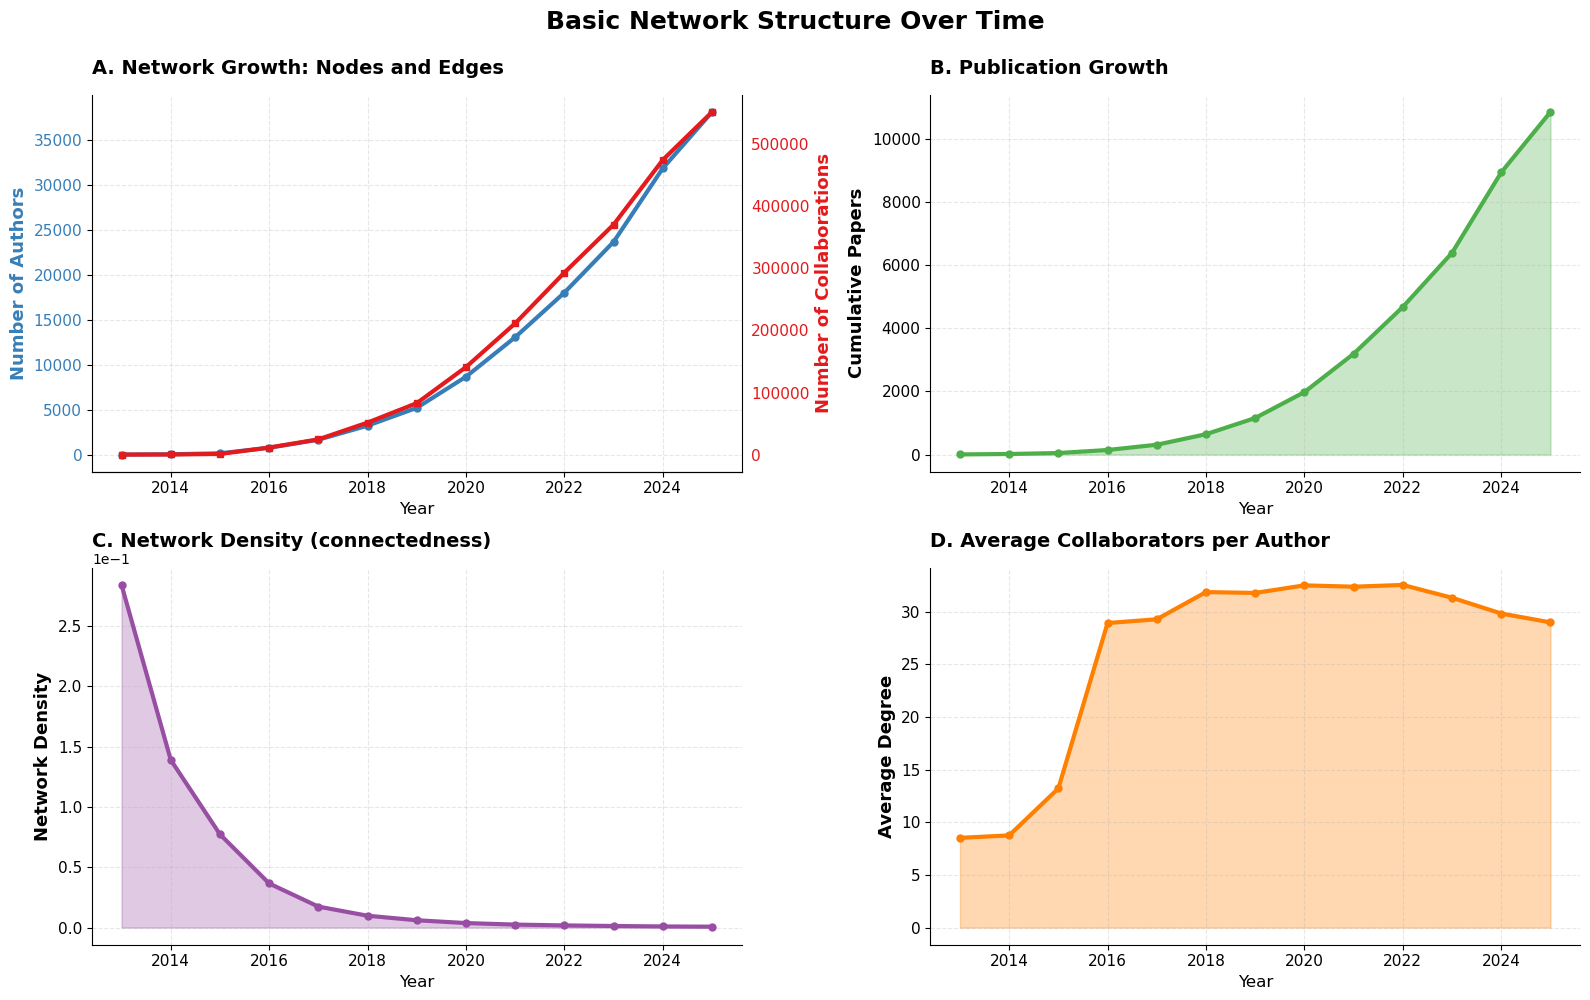

In [21]:
# PLOT 1: Basic Structure & Network Growth

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Basic Network Structure Over Time', fontsize=18, fontweight='bold', y=0.995)

# Panel A: Total nodes and edges
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()
ax1.plot(network_metrics_df.index, network_metrics_df['n_nodes'], 
         color='#377eb8', linewidth=3, marker='o', markersize=5, label='Authors (nodes)')
ax1_twin.plot(network_metrics_df.index, network_metrics_df['n_edges'], 
              color='#e41a1c', linewidth=3, marker='s', markersize=5, label='Collaborations (edges)')
ax1.set_ylabel('Number of Authors', color='#377eb8', fontsize=13, fontweight='bold')
ax1_twin.set_ylabel('Number of Collaborations', color='#e41a1c', fontsize=13, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#377eb8', labelsize=11)
ax1_twin.tick_params(axis='y', labelcolor='#e41a1c', labelsize=11)
ax1.set_title('A. Network Growth: Nodes and Edges', fontsize=14, fontweight='bold', loc='left', pad=15)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax1.tick_params(axis='x', labelsize=11)

# Panel B: Number of papers per year
ax2 = axes[0, 1]
ax2.plot(network_metrics_df.index, network_metrics_df['n_papers'], 
         color='#4daf4a', linewidth=3, marker='o', markersize=5)
ax2.fill_between(network_metrics_df.index, 0, network_metrics_df['n_papers'],
                 alpha=0.3, color='#4daf4a')
ax2.set_ylabel('Cumulative Papers', fontsize=13, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_title('B. Publication Growth', fontsize=14, fontweight='bold', loc='left', pad=15)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax2.tick_params(labelsize=11)

# Panel C: Network density
ax3 = axes[1, 0]
ax3.plot(network_metrics_df.index, network_metrics_df['density'], 
         color='#984ea3', linewidth=3, marker='o', markersize=5)
ax3.fill_between(network_metrics_df.index, 0, network_metrics_df['density'],
                 alpha=0.3, color='#984ea3')
ax3.set_ylabel('Network Density', fontsize=13, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_title('C. Network Density (connectedness)', fontsize=14, fontweight='bold', loc='left', pad=15)
ax3.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax3.tick_params(labelsize=11)
ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Panel D: Average degree
ax4 = axes[1, 1]
ax4.plot(network_metrics_df.index, network_metrics_df['avg_degree'], 
         color='#ff7f00', linewidth=3, marker='o', markersize=5)
ax4.fill_between(network_metrics_df.index, 0, network_metrics_df['avg_degree'],
                 alpha=0.3, color='#ff7f00')
ax4.set_ylabel('Average Degree', fontsize=13, fontweight='bold')
ax4.set_xlabel('Year', fontsize=12)
ax4.set_title('D. Average Collaborators per Author', fontsize=14, fontweight='bold', loc='left', pad=15)
ax4.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax4.tick_params(labelsize=11)

# Apply styling
for ax in axes.flat:
    sns.despine(ax=ax)
sns.despine(ax=ax1_twin, left=True, right=False)

plt.tight_layout()

# Save
output_basic = '../fig/network/metrics_1_basic_structure.pdf'
plt.savefig(output_basic, bbox_inches='tight', dpi=300)
plt.savefig(output_basic.replace('.pdf', '.png'), bbox_inches='tight', dpi=300)
print(f"📊 Plot 1 saved: {output_basic}")

plt.show()

## Enhanced GIF Animation with Metrics Panel

Create an animated GIF showing:
- **Left**: Network visualization (cumulative, showing giant component & isolates)
- **Right**: 3 metric plots vertically stacked:
  1. Network nodes and edges
  2. Average collaborators per author
  3. Giant component growth

Each frame shows a **sliding time window** (e.g., past X years) to keep the right panel focused and readable.

In [12]:
# Configuration for enhanced GIF with metrics panel
import os
from PIL import Image

# Time window for x-axis (years to show in metrics plots)
TIME_WINDOW_YEARS = 12  # Show past 12 years in each frame

# Create directory for enhanced frames
enhanced_frames_dir = '../data/network_frames_with_metrics'
os.makedirs(enhanced_frames_dir, exist_ok=True)
min_year = 2015 
max_year = 2025
print(f"Configuration:")
print(f"  Time window: {TIME_WINDOW_YEARS} years")
print(f"  Frames directory: {enhanced_frames_dir}")

Configuration:
  Time window: 12 years
  Frames directory: ../data/network_frames_with_metrics


In [ ]:
plt.rcParams['font.family'] = 'Helvetica'

In [58]:
# Generate enhanced frames: Network (left) + Metrics (right)

print("Generating enhanced network snapshots with metrics panels...")
print("This may take several minutes for large networks...")

# Select years to visualize (every year)
years_to_plot = list(range(min_year, max_year + 1, 1))
if max_year not in years_to_plot:
    years_to_plot.append(max_year)

enhanced_frame_files = []

for year in tqdm(years_to_plot):
    # Build CUMULATIVE network up to this year
    df_upto_year = df_clean[df_clean['year'] <= year]
    G, author_mapping = build_author_network(df_upto_year)
    
    if G is None or G.number_of_nodes() == 0:
        continue
    
    # Create figure with GridSpec: left for network, right for metrics
    fig = plt.figure(figsize=(16,9))
    gs = fig.add_gridspec(4, 2, width_ratios=[2, 1], hspace=0.35, wspace=0.3,
                          left=0.05, right=0.97, top=0.93, bottom=0.07)
    
    # ========== LEFT: Network Visualization ==========
    ax_network = fig.add_subplot(gs[:, 0])
    
    # Get components for coloring
    components = list(nx.connected_components(G))
    components_sorted = sorted(components, key=len, reverse=True)
    
    # Color scheme
    
    colors_scheme = [ "#B80C09", "#D4AF37", "#6E8B3D","#345995"]
        
    # Assign colors and sizes based on component type
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        component_idx = None
        for idx, comp in enumerate(components_sorted):
            if node in comp:
                component_idx = idx
                break
        
        comp_size = len(components_sorted[component_idx]) if component_idx is not None else 1
        
        if comp_size == 1:  # Isolates
            node_colors.append(colors_scheme[0])
            node_sizes.append(20)
        elif comp_size <= 5:
            node_colors.append(colors_scheme[1])
            node_sizes.append(30)
        elif component_idx == 0:  # Giant component
            node_colors.append(colors_scheme[3])
            node_sizes.append(35)
        else:
            node_colors.append(colors_scheme[2])
            node_sizes.append(25)
    
    # Compute layout
    iterations = 20 if G.number_of_nodes() > 1000 else 40
    pos = nx.spring_layout(G, k=0.3, iterations=iterations, seed=42)
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors, 
                          node_size=node_sizes,
                          alpha=0.7,
                          edgecolors='k',
                          linewidths=0.5,
                          ax=ax_network)
    
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.15, 
                          width=0.3,
                          ax=ax_network)
    
    # Network title - positioned at bottom
    metrics_current = network_metrics_df.loc[year]
    title_text = (f'UK Biobank Co-authorship Network (Through {year})\n' + 
                  f'{metrics_current["n_nodes"]:,.0f} authors • ' +
                  f'{metrics_current["n_edges"]:,.0f} collaborations • ' +
                  f'Giant Component: {metrics_current["giant_nodes"]:,.0f} ' +
                  f'({100*metrics_current["giant_nodes"]/metrics_current["n_nodes"]:.1f}%)')
    
    ax_network.text(0.5, 0.01, title_text, transform=ax_network.transAxes,
                    fontsize=13, fontweight='bold', ha='center', va='bottom')
                    #bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1))
    
    ax_network.axis('off')
    
    # Add legend
    legend_elements = [
        mlines.Line2D([], [], color=colors_scheme[0], marker='o', linestyle='None',
                     markersize=10, label='Isolates', markeredgecolor='k', markeredgewidth=0.5, alpha=0.7),
        mlines.Line2D([], [], color=colors_scheme[3], marker='o', linestyle='None',
                     markersize=12, label='Giant Component', markeredgecolor='k', markeredgewidth=0.5, alpha=0.7)
    ]
    ax_network.legend(handles=legend_elements,bbox_to_anchor=(0.9, 0.1), frameon=True, 
                     framealpha=0.95, edgecolor='k', fontsize=11)
    
    # ========== RIGHT: Metrics Panels (3 stacked vertically) ==========
    
    # Determine time window for x-axis
    x_min = max(min_year, year - TIME_WINDOW_YEARS + 1)
    x_max = max_year  # Always show full x-axis to max_year
    
    # Filter data for this time window (up to current year)
    data_mask = (network_metrics_df.index >= x_min) & (network_metrics_df.index <= year)
    data_window = network_metrics_df[data_mask]
    

    # Panel 0: Nodes 
    ax0 = fig.add_subplot(gs[0, 1])
    
    ax0.plot(data_window.index, data_window['n_nodes'], 
             color="#345995", linewidth=2.5, marker='o', markersize=4, label='Authors')
    ax0.fill_between(data_window.index, 0, data_window['n_nodes'], alpha=0.3, color="#345995")
    
    #ax0.set_ylabel('Authors', fontsize=13, fontweight='bold')
    ax0.tick_params(labelsize=9)

    ax0.set_ylim(-5,40000)
    ax0.set_xlim(x_min-0.5, x_max+1)
    ax0.set_title('Network Growth - Authors', fontsize=12, fontweight='bold', loc='left', pad=8)
    ax0.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax0.tick_params(axis='x', labelsize=9)
    ax0.set_xlabel('')
    
    
    # Panel 1: Nodes and Edges
    ax1 = fig.add_subplot(gs[1, 1])
    
    ax1.plot(data_window.index, data_window['n_edges'], 
                  color="#B80C09", linewidth=2.5, marker='o', markersize=4, label='Collaborations')
    ax1.fill_between(data_window.index, 0, data_window['n_edges'], 
                     alpha=0.3, color="#B80C09")
    #ax1.set_ylabel('Collaborations', fontsize=13, fontweight='bold')
    ax1.set_ylim(-5,580000)
    ax1.tick_params(labelsize=9)
    ax1.set_xlim(x_min-0.5, x_max+1)
    ax1.set_title('Network Growth - Collaborations', fontsize=12, fontweight='bold', loc='left', pad=8)
    ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax1.tick_params(axis='x', labelsize=9)
    ax1.set_xlabel('')
    
    # Panel 2: Average Degree (Collaborators per Author)
    ax2 = fig.add_subplot(gs[2, 1])
    
    ax2.plot(data_window.index, data_window['avg_degree'], 
             color= "#D4AF37", linewidth=2.5, marker='o', markersize=4)
    ax2.fill_between(data_window.index, 0, data_window['avg_degree'],
                     alpha=0.3, color= "#D4AF37")
    
    #ax2.set_ylabel('Avg Degree', fontsize=13, fontweight='bold')
    ax2.set_xlim(x_min-0.5,x_max+1)
    ax2.set_title('Avg Collaborators per Author', fontsize=12, fontweight='bold', loc='left', pad=8)
    ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax2.tick_params(labelsize=9)
    ax2.set_ylim(0,33)
    ax2.set_xlabel('')
    
    # Panel 3: Giant Component Growth
    ax3 = fig.add_subplot(gs[3, 1])
    
    ax3.plot(data_window.index, data_window['giant_nodes'], 
             color="#6E8B3D", linewidth=2.5, marker='o', markersize=4)
    ax3.fill_between(data_window.index, 0, data_window['giant_nodes'],
                     alpha=0.3, color="#6E8B3D")
    
    #ax3.set_ylabel('Giant Component', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax3.set_xlim(x_min-0.5, x_max+1)
    ax3.set_title('Giant Component Size', fontsize=12, fontweight='bold', loc='left', pad=8)
    ax3.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax3.tick_params(labelsize=9)
    ax3.set_ylim(-5,35000)
    
    # Apply styling
    sns.despine(ax=ax1)
    sns.despine(ax=ax0)
    sns.despine(ax=ax2)
    sns.despine(ax=ax3)

    
    # Save frame
    frame_file = os.path.join(enhanced_frames_dir, f'network_enhanced_{year}.png')
    plt.savefig(frame_file, bbox_inches='tight', dpi=150, facecolor='white')
    plt.close()
    
    enhanced_frame_files.append(frame_file)
    
    




Generating enhanced network snapshots with metrics panels...
This may take several minutes for large networks...


100%|██████████| 11/11 [1:00:00<00:00, 327.32s/it]


In [63]:
# Create enhanced animated GIF

print("Creating enhanced animated GIF with metrics panel...")

# Load all enhanced frames
enhanced_frames = []
for frame_file in enhanced_frame_files:
    img = Image.open(frame_file)
    enhanced_frames.append(img)

# Save as GIF
enhanced_gif_path = '../fig/network/network_evolution_with_metrics.gif'
enhanced_frames[0].save(
    enhanced_gif_path,
    save_all=True,
    append_images=enhanced_frames[1:],
    duration=2000,  # milliseconds per frame 
    loop=0  # 
)


Creating enhanced animated GIF with metrics panel...
